In [1]:
# Nativos
import random as rn
import os
import sys
import gc

#calculo
import numpy as np
import pandas as pd
import scipy

import pandas as pd
import scorecardpy as sc

SEED = 29082013
os.environ['PYTHONHASHSEED']=str(SEED)
np.random.seed(SEED)
rn.seed(SEED)

In [2]:
x_train = pd.read_csv("X_train.csv")
x_valid = pd.read_csv("X_valid.csv")

y_train = pd.read_csv("y_train.csv")
y_valid = pd.read_csv("y_valid.csv")

x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((51120, 60), (12781, 60), (51120, 1), (12781, 1))

In [3]:
def calcular_pesos(modelo):
    coef_model = pd.DataFrame(modelo.tvalues,columns=['t_value'])
    coef_model['t_value2'] = np.power(coef_model['t_value'],2)
    coef_model['total'] = sum(coef_model['t_value2'])
    coef_model['part'] = coef_model['t_value2'] / coef_model['total']
    coef_model['pesos'] = coef_model['part'] * 100
    return coef_model['pesos'].sort_values(ascending=True)



### >> Modleo TOP IV

In [4]:
cols_aporte = [
     'autocontrol_x_confianza_entre_tiempo_empleo',
     'saldo_cuenta_x_confianza_entre_tiempo_empleo',
     'autocontrol_x_impulsividad_entre_tiempo_empleo',
     'valor_prestamo_x_saldo_cuenta',
     'valor_prestamo_x_impulsividad_entre_tiempo_empleo',
     'saldo_cuenta_x_autocontrol',
     'Saldo_cuenta',
     'tiempo_empleo_x_impulsividad_entre_cuentas_otros',
     'valor_prestamo_x_autocontrol_entre_tiempo_empleo',
     'valor_prestamo_x_saldo_cuenta_entre_tiempo_empleo',
     'impulsividad_x_confianza_entre_tiempo_empleo',
     'cuentas_otros_x_autocontrol_entre_tiempo_empleo',
     'cuentas_otros_x_impulsividad_entre_tiempo_empleo'
]

In [5]:
x_train['target'] = y_train.values
matriz_corr = x_train[cols_aporte + ['target']].corr(method='pearson')

matriz_corr.style.background_gradient(
    cmap='coolwarm', axis=None
).set_precision(5)

,autocontrol_x_confianza_entre_tiempo_empleo,saldo_cuenta_x_confianza_entre_tiempo_empleo,autocontrol_x_impulsividad_entre_tiempo_empleo,valor_prestamo_x_saldo_cuenta,valor_prestamo_x_impulsividad_entre_tiempo_empleo,saldo_cuenta_x_autocontrol,Saldo_cuenta,tiempo_empleo_x_impulsividad_entre_cuentas_otros,valor_prestamo_x_autocontrol_entre_tiempo_empleo,valor_prestamo_x_saldo_cuenta_entre_tiempo_empleo,impulsividad_x_confianza_entre_tiempo_empleo,cuentas_otros_x_autocontrol_entre_tiempo_empleo,cuentas_otros_x_impulsividad_entre_tiempo_empleo,target
autocontrol_x_confianza_entre_tiempo_empleo,1.00000,0.14549,0.92987,-0.00224,0.78822,0.00700,-0.00224,-0.17768,0.84651,0.14207,0.93228,0.57023,0.53063,-0.00070
saldo_cuenta_x_confianza_entre_tiempo_empleo,0.14549,1.00000,0.13593,0.53850,0.11790,0.66638,0.65321,-0.02451,0.12208,0.86237,0.14280,0.07720,0.07387,-0.00398
autocontrol_x_impulsividad_entre_tiempo_empleo,0.92987,0.13593,1.00000,-0.00202,0.84770,0.00895,-0.00031,-0.16142,0.84551,0.13969,0.93097,0.56949,0.57034,-0.00149
valor_prestamo_x_saldo_cuenta,-0.00224,0.53850,-0.00202,1.00000,0.02255,0.84631,0.86824,0.00440,0.02413,0.65491,-0.00404,-0.00072,-0.00313,-0.00652
valor_prestamo_x_impulsividad_entre_tiempo_empleo,0.78822,0.11790,0.84770,0.02255,1.00000,-0.00152,-0.00391,-0.14544,0.93771,0.16195,0.84472,0.47910,0.51255,0.00110
saldo_cuenta_x_autocontrol,0.00700,0.66638,0.00895,0.84631,-0.00152,1.00000,0.98034,0.00418,0.00652,0.58772,-0.00074,0.00396,-0.00227,-0.00699
Saldo_cuenta,-0.00224,0.65321,-0.00031,0.86824,-0.00391,0.98034,1.00000,0.00517,-0.00219,0.57213,-0.00321,-0.00236,-0.00442,-0.00690
tiempo_empleo_x_impulsividad_entre_cuentas_otros,-0.17768,-0.02451,-0.16142,0.00440,-0.14544,0.00418,0.00517,1.00000,-0.16034,-0.02660,-0.16123,-0.03974,-0.02663,-0.00045
valor_prestamo_x_autocontrol_entre_tiempo_empleo,0.84651,0.12208,0.84551,0.02413,0.93771,0.00652,-0.00219,-0.16034,1.00000,0.16782,0.78512,0.51676,0.47865,-0.00087
valor_prestamo_x_saldo_cuenta_entre_tiempo_empleo,0.14207,0.86237,0.13969,0.65491,0.16195,0.58772,0.57213,-0.02660,0.16782,1.00000,0.13666,0.08680,0.08076,-0.00590


In [6]:
pd.DataFrame(matriz_corr['target'].abs().sort_values(ascending=False)).style.background_gradient(
    cmap='coolwarm', axis=None
).set_precision(5)

,target
target,1.00000
saldo_cuenta_x_autocontrol,0.00699
Saldo_cuenta,0.00690
valor_prestamo_x_saldo_cuenta,0.00652
valor_prestamo_x_saldo_cuenta_entre_tiempo_empleo,0.00590
saldo_cuenta_x_confianza_entre_tiempo_empleo,0.00398
autocontrol_x_impulsividad_entre_tiempo_empleo,0.00149
valor_prestamo_x_impulsividad_entre_tiempo_empleo,0.00110
cuentas_otros_x_autocontrol_entre_tiempo_empleo,0.00093
valor_prestamo_x_autocontrol_entre_tiempo_empleo,0.00087


In [7]:
matriz_corr = x_train[cols_aporte + ['target']].corr(method='spearman')

matriz_corr.style.background_gradient(
    cmap='coolwarm', axis=None
).set_precision(5)

,autocontrol_x_confianza_entre_tiempo_empleo,saldo_cuenta_x_confianza_entre_tiempo_empleo,autocontrol_x_impulsividad_entre_tiempo_empleo,valor_prestamo_x_saldo_cuenta,valor_prestamo_x_impulsividad_entre_tiempo_empleo,saldo_cuenta_x_autocontrol,Saldo_cuenta,tiempo_empleo_x_impulsividad_entre_cuentas_otros,valor_prestamo_x_autocontrol_entre_tiempo_empleo,valor_prestamo_x_saldo_cuenta_entre_tiempo_empleo,impulsividad_x_confianza_entre_tiempo_empleo,cuentas_otros_x_autocontrol_entre_tiempo_empleo,cuentas_otros_x_impulsividad_entre_tiempo_empleo,target
autocontrol_x_confianza_entre_tiempo_empleo,1.00000,0.59936,0.95458,-0.00660,0.72956,0.01660,-0.00265,0.22954,0.76505,0.46950,0.95440,0.37290,0.35672,0.00027
saldo_cuenta_x_confianza_entre_tiempo_empleo,0.59936,1.00000,0.58677,0.52448,0.47204,0.65334,0.65733,0.34374,0.47089,0.80074,0.60066,0.23538,0.23584,-0.00447
autocontrol_x_impulsividad_entre_tiempo_empleo,0.95458,0.58677,1.00000,-0.00411,0.76517,0.01954,0.00040,0.24389,0.76542,0.47151,0.95440,0.37270,0.37247,-0.00033
valor_prestamo_x_saldo_cuenta,-0.00660,0.52448,-0.00411,1.00000,0.28965,0.79983,0.80431,0.00050,0.28858,0.75252,-0.00716,-0.00012,0.00018,-0.00716
valor_prestamo_x_impulsividad_entre_tiempo_empleo,0.72956,0.47204,0.76517,0.28965,1.00000,0.00259,0.00165,0.19940,0.96757,0.71293,0.76369,0.28804,0.30044,0.00009
saldo_cuenta_x_autocontrol,0.01660,0.65334,0.01954,0.79983,0.00259,1.00000,0.99384,0.00060,0.01634,0.52823,-0.00084,0.00582,-0.00040,-0.00815
Saldo_cuenta,-0.00265,0.65733,0.00040,0.80431,0.00165,0.99384,1.00000,0.00050,0.00032,0.53089,-0.00120,-0.00114,-0.00048,-0.00791
tiempo_empleo_x_impulsividad_entre_cuentas_otros,0.22954,0.34374,0.24389,0.00050,0.19940,0.00060,0.00050,1.00000,0.18669,0.27981,0.24473,0.58461,0.59381,0.00066
valor_prestamo_x_autocontrol_entre_tiempo_empleo,0.76505,0.47089,0.76542,0.28858,0.96757,0.01634,0.00032,0.18669,1.00000,0.71188,0.72824,0.29928,0.28626,-0.00022
valor_prestamo_x_saldo_cuenta_entre_tiempo_empleo,0.46950,0.80074,0.47151,0.75252,0.71293,0.52823,0.53089,0.27981,0.71188,1.00000,0.46881,0.19173,0.19192,-0.00360


In [8]:
pd.DataFrame(matriz_corr['target'].abs().sort_values(ascending=False)).style.background_gradient(
    cmap='coolwarm', axis=None
).set_precision(5)

,target
target,1.00000
saldo_cuenta_x_autocontrol,0.00815
Saldo_cuenta,0.00791
valor_prestamo_x_saldo_cuenta,0.00716
saldo_cuenta_x_confianza_entre_tiempo_empleo,0.00447
valor_prestamo_x_saldo_cuenta_entre_tiempo_empleo,0.00360
cuentas_otros_x_autocontrol_entre_tiempo_empleo,0.00087
tiempo_empleo_x_impulsividad_entre_cuentas_otros,0.00066
cuentas_otros_x_impulsividad_entre_tiempo_empleo,0.00065
impulsividad_x_confianza_entre_tiempo_empleo,0.00043


In [9]:
del x_train['target']

In [10]:
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, TimeSeriesSplit, RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

kfold_off_on = RepeatedStratifiedKFold(
    n_splits=3, 
    n_repeats=2,
    random_state=SEED
)

param_grid_arbol = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],             
    'min_samples_split': [0.03, 0.05, 0.07, 0.1],
    'max_depth': [2, 3, 4, 5, 6, 7],
    'max_features': [0.8, 0.85, 0.9, 0.95, 1.0],
    'random_state': [SEED],
    'class_weight': ['balanced', None],
    'ccp_alpha': [0, 0.001, 0.005, 0.01]
}
model_arbol = DecisionTreeClassifier(random_state=SEED)

grid_arbol = RandomizedSearchCV(
    model_arbol, 
    {k: [v] if not isinstance(v, list) else v for k, v in param_grid_arbol.items()}, 
    cv=kfold_off_on, 
    n_jobs=4, 
    scoring='roc_auc', 
    verbose=2,
    n_iter=1000,
    refit=True
)

In [11]:
%%time
grid_arbol.fit(
    x_train[cols_aporte],
    y_train,
)

best_params_arbol = grid_arbol.best_params_
score_arbol = grid_arbol.best_score_
result_2 = grid_arbol.best_estimator_

print("score: ", score_arbol)

Fitting 6 folds for each of 1000 candidates, totalling 6000 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    3.9s
[Parallel(n_jobs=4)]: Done 228 tasks      | elapsed:   11.1s
[Parallel(n_jobs=4)]: Done 634 tasks      | elapsed:   32.6s
[Parallel(n_jobs=4)]: Done 1200 tasks      | elapsed:   56.1s
[Parallel(n_jobs=4)]: Done 1930 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 2820 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done 3874 tasks      | elapsed:  3.1min
[Parallel(n_jobs=4)]: Done 5088 tasks      | elapsed:  4.0min
[Parallel(n_jobs=4)]: Done 6000 out of 6000 | elapsed:  4.7min finished


score:  0.5030837242238189
Wall time: 4min 41s


In [12]:
best_params_arbol

{'splitter': 'best',
 'random_state': 29082013,
 'min_samples_split': 0.1,
 'max_features': 0.9,
 'max_depth': 5,
 'criterion': 'gini',
 'class_weight': None,
 'ccp_alpha': 0}

In [13]:
import numpy as np
#prediciendo en base al modelo 
y_pred_prob_2_train = result_2.predict(x_train[cols_aporte])
y_pred_class_2_train = np.where(y_pred_prob_2_train < 0.5, 0 , 1)

y_pred_prob_2_valid = result_2.predict(x_valid[cols_aporte])
y_pred_class_2_valid = np.where(y_pred_prob_2_valid < 0.5, 0 , 1)

<AxesSubplot:>

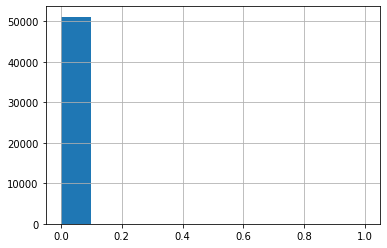

In [15]:
pd.Series(y_pred_prob_2_train).hist()

<AxesSubplot:>

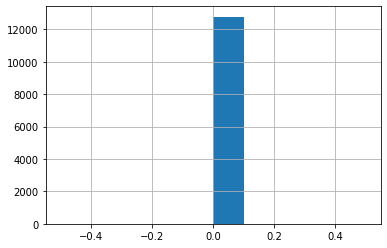

In [16]:
pd.Series(y_pred_prob_2_valid).hist()

In [17]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score

print("/"*25, 'TRAIN')
auc = roc_auc_score(y_train, y_pred_prob_2_train)
print("AUC: %1.3f" % auc)
print("GINI: %1.3f" % (2*auc-1))

print("/"*25, 'VALIDATION')
auc_2 = roc_auc_score(y_valid, y_pred_prob_2_valid)
print("AUC: %1.3f" % auc_2)
print("GINI: %1.3f" % (2*auc_2-1))

///////////////////////// TRAIN
AUC: 0.500
GINI: 0.001
///////////////////////// VALIDATION
AUC: 0.500
GINI: 0.000


In [18]:
print("/"*25, 'TRAIN')
print("RECALL     : %1.8f" % recall_score(y_train, y_pred_class_2_train))
print("EFECTIVIDAD: %1.8f" % precision_score(y_train, y_pred_class_2_train))
print("F1 SCORE   : %1.8f" % f1_score(y_train, y_pred_class_2_train))

print("/"*25, 'VALIDATION')
print("RECALL     : %1.8f" % recall_score(y_valid, y_pred_class_2_valid))
print("EFECTIVIDAD: %1.8f" % precision_score(y_valid, y_pred_class_2_valid))
print("F1 SCORE   : %1.8f" % f1_score(y_valid, y_pred_class_2_valid))

///////////////////////// TRAIN
RECALL     : 0.00055432
EFECTIVIDAD: 0.80000000
F1 SCORE   : 0.00110788
///////////////////////// VALIDATION
RECALL     : 0.00000000
EFECTIVIDAD: 0.00000000
F1 SCORE   : 0.00000000


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### >>> RECALL

In [19]:
from scipy.optimize import differential_evolution


optimization_rec = differential_evolution(
    lambda c: -1*recall_score(y_train, np.array([0 if _ < c[0] else 1 for _ in y_pred_prob_2_train])), 
    [(0, 1)],
    seed=SEED
)
optimization_rec

     fun: -0.0005543237250554324
 message: 'Optimization terminated successfully.'
    nfev: 32
     nit: 1
 success: True
       x: array([0.11725487])

In [20]:
corte_rec = optimization_rec['x'][0]
corte_rec

0.11725487017104697

In [21]:
y_pred_class_train_2_rec = np.where(y_pred_prob_2_train < corte_rec, 0 , 1)
y_pred_class_valid_2_rc = np.where(y_pred_prob_2_valid < corte_rec, 0 , 1)

In [22]:
pd.Series(y_pred_class_train_2_rec).value_counts()

0    51115
1        5
dtype: int64

In [23]:
pd.Series(y_pred_class_valid_2_rc).value_counts()

0    12781
dtype: int64

In [24]:
print("/"*25, "TRAIN")
print("RECALL     : %1.8f" % recall_score(y_train, y_pred_class_train_2_rec))
print("EFECTIVIDAD: %1.8f" % precision_score(y_train, y_pred_class_train_2_rec))
print("F1 SCORE   : %1.8f" % f1_score(y_train, y_pred_class_train_2_rec))

print("/"*25, "VALIDATION")
print("RECALL     : %1.8f" % recall_score(y_valid, y_pred_class_valid_2_rc))
print("EFECTIVIDAD: %1.8f" % precision_score(y_valid, y_pred_class_valid_2_rc))
print("F1 SCORE   : %1.8f" % f1_score(y_valid, y_pred_class_valid_2_rc))

///////////////////////// TRAIN
RECALL     : 0.00055432
EFECTIVIDAD: 0.80000000
F1 SCORE   : 0.00110788
///////////////////////// VALIDATION
RECALL     : 0.00000000
EFECTIVIDAD: 0.00000000
F1 SCORE   : 0.00000000


#### >>> EFECTIVIDAD

In [25]:
optimization_pre = differential_evolution(
    lambda c: -1*precision_score(y_train, np.array([0 if _ < c[0] else 1 for _ in y_pred_prob_2_train])), 
    [(0, 1)],
    seed=SEED
)
optimization_pre

     fun: -0.8
 message: 'Optimization terminated successfully.'
    nfev: 32
     nit: 1
 success: True
       x: array([0.11725487])

#### >>> AUC

In [26]:
optimization_auc = differential_evolution(
    lambda c: -1*roc_auc_score(y_train, np.array([0 if _ < c[0] else 1 for _ in y_pred_prob_2_train])), 
    [(0, 1)],
    seed=SEED
)
optimization_auc

     fun: -0.5002657733785627
 message: 'Optimization terminated successfully.'
    nfev: 32
     nit: 1
 success: True
       x: array([0.11725487])

In [27]:
corte_auc = optimization_auc['x'][0]
corte_auc

0.11725487017104697

In [28]:
y_pred_class_train_2_auc = np.where(y_pred_prob_2_train < corte_auc, 0 , 1)
y_pred_class_valid_2_auc = np.where(y_pred_prob_2_valid < corte_auc, 0 , 1)

In [29]:
pd.Series(y_pred_class_train_2_auc).value_counts()

0    51115
1        5
dtype: int64

In [30]:
pd.Series(y_pred_class_valid_2_auc).value_counts()

0    12781
dtype: int64

In [31]:
print("/"*25, "TRAIN")
print("RECALL     : %1.8f" % recall_score(y_train, y_pred_class_train_2_auc))
print("EFECTIVIDAD: %1.8f" % precision_score(y_train, y_pred_class_train_2_auc))
print("F1 SCORE   : %1.8f" % f1_score(y_train, y_pred_class_train_2_auc))

print("/"*25, "VALIDATION")
print("RECALL     : %1.8f" % recall_score(y_valid, y_pred_class_valid_2_auc))
print("EFECTIVIDAD: %1.8f" % precision_score(y_valid, y_pred_class_valid_2_auc))
print("F1 SCORE   : %1.8f" % f1_score(y_valid, y_pred_class_valid_2_auc))

///////////////////////// TRAIN
RECALL     : 0.00055432
EFECTIVIDAD: 0.80000000
F1 SCORE   : 0.00110788
///////////////////////// VALIDATION
RECALL     : 0.00000000
EFECTIVIDAD: 0.00000000
F1 SCORE   : 0.00000000


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
